# Installations

In [ ]:
# Installations

# install once necessary libraries

!pip install pandas
!pip install -U scikit-learn
!pip install pm4py
!pip install kneed
!pip install torch

# Import Event Log

In [1]:
import pandas as pd
import numpy as np
import pm4py
from pm4py.objects.conversion.log import converter as log_converter


if __name__ == "__main__":
    # Read the CSV file
    dataframe = pd.read_csv('model_A.csv', sep=',')  

    # Drop the first column without knowing its name
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)

    # Format the dataframe
    dataframe = pm4py.format_dataframe(
        dataframe, 
        case_id='case:concept:name', 
        activity_key='concept:name', 
        timestamp_key='time:timestamp'
    )

    # Convert the dataframe to event log
    log = log_converter.apply(dataframe)
    
dataframe

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)


,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,@@index,@@case_index
0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,0,0
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,1,0
2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,2,0
3,10862,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,3,0
4,10862,COMPLETE,A_FINALIZED,2011-10-01 11:45:09.243000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,4,0
...,...,...,...,...,...,...,...,...,...
60844,10933,COMPLETE,A_ACCEPTED,2012-03-01 20:17:22.457000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,60844,13085
60845,10933,COMPLETE,A_FINALIZED,2012-03-01 20:22:38.593000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,60845,13085
60846,112,COMPLETE,A_SUBMITTED,2012-02-29 23:51:16.799000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,60846,13086
60847,112,COMPLETE,A_PARTLYSUBMITTED,2012-02-29 23:51:17.423000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,60847,13086


# Data Preprocessing

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer

# Step 1: One-Hot Encoding of Activities
mlb = MultiLabelBinarizer()
traces = dataframe.groupby('@@case_index')['concept:name'].apply(list)
one_hot_encoded = mlb.fit_transform(traces)

# Clustering

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default 

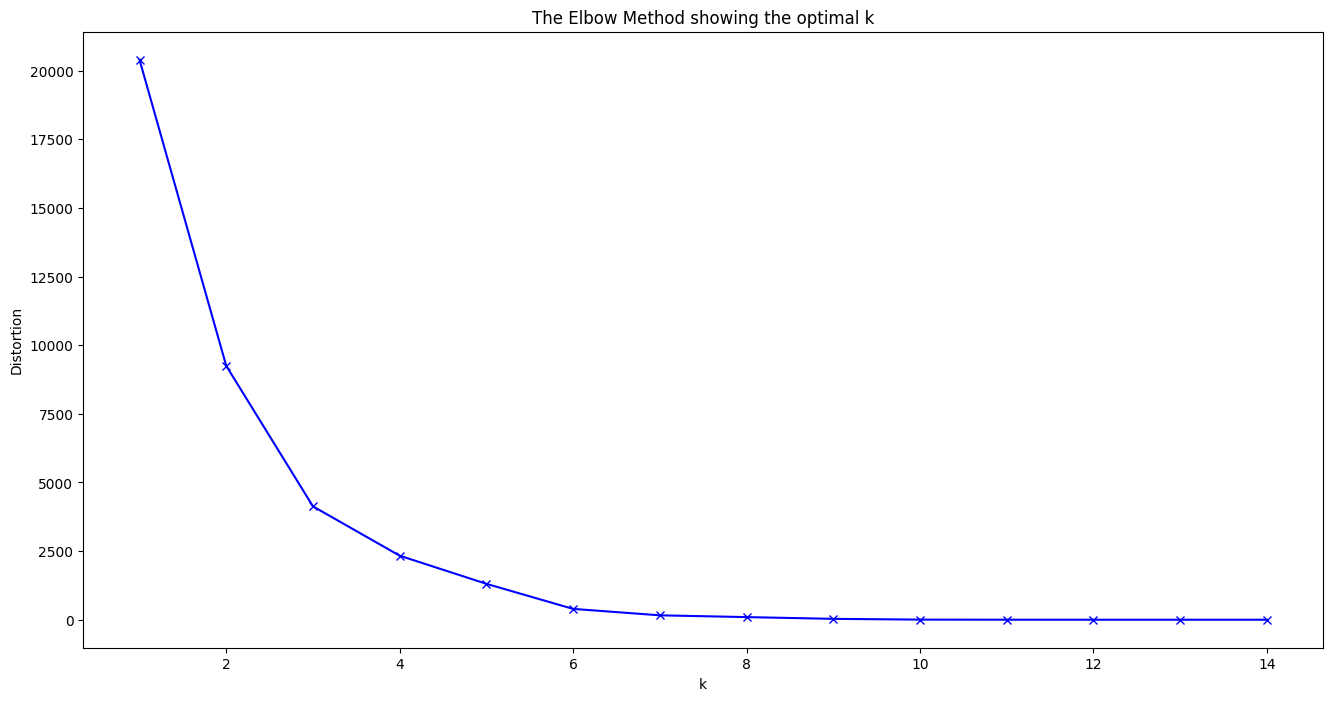

Optimal number of clusters: 4


In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
import numpy as np

# Convert trace_vectors into a 2D array, which can be directly fed to KMeans
one_hot_encoding = np.array(one_hot_encoded.tolist())

distortions = []
K = range(1, 15)  # Check for number of clusters from 1 to 15, adjust according to your data
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(one_hot_encoding)
    distortions.append(kmeans.inertia_)  # Inertia: sum of squared distances of samples to their closest cluster center

# Plot the elbow
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Find the elbow point using KneeLocator
kl = KneeLocator(K, distortions, curve='convex', direction='decreasing')
print("Optimal number of clusters:", kl.elbow)

In [4]:
from sklearn.cluster import KMeans

# Number of clusters
k = kl.elbow

# Create a KMeans instance with k clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to the data
kmeans.fit(one_hot_encoding)

# Predict the clusters for each trace
clusters = kmeans.predict(one_hot_encoding)

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Cluster Evaluation

In [5]:
# the value of the silhouette coefficient ranges between -1 and 1
# value close to 1 is considered as good

from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(one_hot_encoding, clusters)

print(f"Silhouette Coefficient: {silhouette_avg:.2f}")

Silhouette Coefficient: 0.80


# Token-Based Replay for Conformance Checking

In [39]:
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("Model_A_corrected.bpmn")

# 3. Convert the BPMN to a Petri net
net, im, fm = pm4py.convert_to_petri_net(bpmn_graph)

# 4. Perform alignment-based conformance checking
alignments = alignments_petri.apply(log, net, im, fm)

# Calculate and print diagnostics
fit_traces = sum(1 for trace in alignments if trace['fitness'] == 1.0)

print(f"Total traces: {len(log)}")
print(f"Conform traces: {fit_traces}")
print(f"Non-Conform traces: {len(log) - fit_traces}")

aligning log, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

Total traces: 13087
Conform traces: 11497
Non-Conform traces: 1590


# Input Traces

In [7]:
trace1 = ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED']
trace2 = ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_ACCEPTED', 'A_FINALIZED', 'A_CANCELLED']
trace3 = ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_CANCELLED']

In [8]:
grouped = dataframe.groupby('@@case_index')['concept:name'].apply(list).reset_index(name='trace')

In [9]:
def is_happy_trace(row_trace):
    predefined_traces = [trace1, trace2, trace3]
    for trace in predefined_traces:
        if row_trace == trace:
            return 1
    return 0

In [10]:
grouped['happy'] = grouped['trace'].apply(is_happy_trace)
grouped

,@@case_index,trace,happy
0,0,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",0
1,1,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",0
2,2,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",0
3,3,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",1
4,4,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",1
...,...,...,...
13082,13082,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",0
13083,13083,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",1
13084,13084,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",1
13085,13085,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",0


In [11]:
# Get indices of the happy traces in the results dataframe
happy_trace_indices = grouped[grouped['happy'] == 1].index.tolist()

# Extract the corresponding coordinates from the trace_representations array
happy_trace_coordinates = one_hot_encoding[happy_trace_indices]

# Extract unique coordinates
unique_happy_trace_coordinates = np.unique(happy_trace_coordinates, axis=0)

# Assuming the size of unique_happy_trace_coordinates is 3
#happy_trace1, happy_trace2, happy_trace3 = unique_happy_trace_coordinates
happy_trace1, happy_trace2, happy_trace3 = unique_happy_trace_coordinates

# Distance Measurement

In [12]:
from scipy.spatial.distance import euclidean

# Calculate the distances to each of the happy traces for every trace representation
distances_to_happy_traces = []

for trace_representation in one_hot_encoding:
    distances = [
        euclidean(trace_representation, happy_trace1),
        euclidean(trace_representation, happy_trace2),
        euclidean(trace_representation, happy_trace3)
    ]
    distances_to_happy_traces.append(distances)

# Calculate the average distance to the happy traces for each trace representation
avg_distances = [np.mean(distances) for distances in distances_to_happy_traces]

# Save the distances in a variable
avg_distances_var = np.array(avg_distances)

# Results overview

In [13]:
# create dataframe with necessary information for distance measurement

#grouped = dataframe.groupby('@@case_index')['concept:name'].apply(list).reset_index(name='trace')

results = pd.DataFrame(grouped['trace'])

results['cluster'] = clusters

conformity_array = [int(trace['fitness']) for trace in alignments]
results['conform'] = conformity_array

results['distance'] = avg_distances_var

results

,trace,cluster,conform,distance
0,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",2,0,2.365080
1,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",2,1,2.365080
2,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",2,1,2.365080
3,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",0,1,1.322706
4,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",0,1,1.322706
...,...,...,...,...
13082,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",1,0,1.577350
13083,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",0,1,1.322706
13084,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",0,1,1.322706
13085,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",1,0,1.577350


In [14]:
summary = results.groupby('cluster').agg(
    count=pd.NamedAgg(column='trace', aggfunc='size'),
    conform_count=pd.NamedAgg(column='conform', aggfunc='sum')
).reset_index()

print("cluster\tcount\tconform_count")
for _, row in summary.iterrows():
    print(f"{row['cluster']}\t{row['count']}\t{row['conform_count']}")

cluster	count	conform_count
0	6833	6833
1	2772	2442
2	2246	1055
3	1236	1167


# Results Visualization

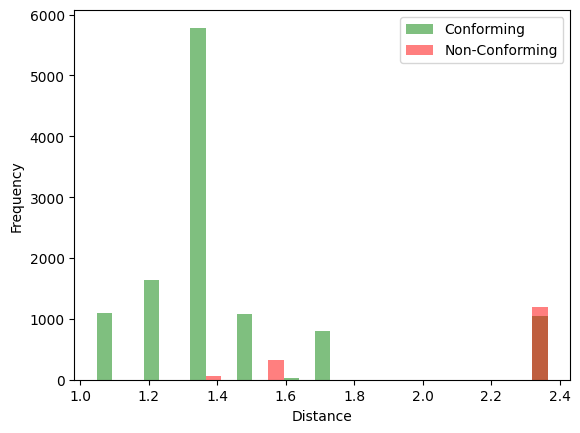

In [15]:
import matplotlib.pyplot as plt

# Filter the DataFrame into conforming and non-conforming subsets
conforming_distances = results[results['conform'] == 1]['distance']
non_conforming_distances = results[results['conform'] == 0]['distance']

# Determine common bin edges
min_distance = min(results['distance'])
max_distance = max(results['distance'])
bin_edges = np.linspace(min_distance, max_distance, num=30)

# Plot histograms with common bin edges
plt.hist(conforming_distances, bins=bin_edges, alpha=0.5, label='Conforming', color='green')
plt.hist(non_conforming_distances, bins=bin_edges, alpha=0.5, label='Non-Conforming', color='red')

# Add labels and legend
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

# Evaluation - Conformance Checking without Process Model

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


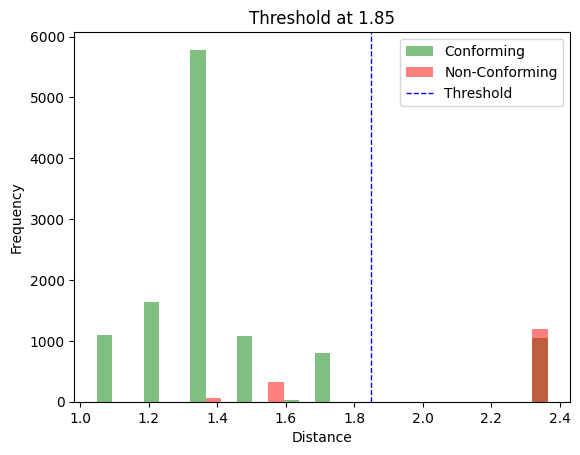

In [16]:
from sklearn.cluster import KMeans

# Filter the DataFrame into conforming and non-conforming subsets
conforming_distances = results[results['conform'] == 1]['distance']
non_conforming_distances = results[results['conform'] == 0]['distance']

# Determine common bin edges
min_distance = min(results['distance'])
max_distance = max(results['distance'])
bin_edges = np.linspace(min_distance, max_distance, num=30)

# Combine the data and reshape for k-means
all_distances = results['distance']
all_distances = np.array(all_distances)
all_distances_reshaped = all_distances.reshape(-1, 1)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_distances_reshaped)
kmeans_labels = kmeans.labels_

# Find the threshold as the average of the two cluster centers
threshold_value = np.mean(kmeans.cluster_centers_)

# Plot histograms and the threshold
plt.hist(conforming_distances, bins=bin_edges, alpha=0.5, label='Conforming', color='green')
plt.hist(non_conforming_distances, bins=bin_edges, alpha=0.5, label='Non-Conforming', color='red')
plt.axvline(threshold_value, color='blue', linestyle='dashed', linewidth=1, label='Threshold')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title(f'Threshold at {threshold_value:.2f}')

plt.savefig('Model_A_Threshold.png', dpi=300, bbox_inches='tight')

plt.show()

In [17]:
true_positive = np.sum(results[results['conform'] == 1]['distance'] < threshold_value)
true_negative = np.sum(results[results['conform'] == 0]['distance'] > threshold_value)
false_positive = np.sum(results[results['conform'] == 0]['distance'] < threshold_value)
false_negative = np.sum(results[results['conform'] == 1]['distance'] > threshold_value)

In [18]:
# Calculate accuracy
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.889


In [19]:
# Calculate precision
precision = true_positive / (true_positive + false_positive)
print(f"Precision: {precision:.3f}")

Precision: 0.963


In [20]:
# Calculate recall
recall = true_positive / (true_positive + false_negative)
print(f"Recall: {recall:.3f}")

Recall: 0.908


In [21]:
# Calculate f1
f1 = 2 * ((precision * recall) / (precision + recall))
print(f"F1: {f1:.3f}")

F1: 0.935


# Dev (Non Conform Traces)

In [22]:
# Calculate precision
precision = true_negative / (true_negative + false_negative)
print(f"Precision: {precision:.3f}")

Precision: 0.530


In [23]:
# Calculate recall
recall = true_negative / (true_negative + false_positive)
print(f"Recall: {recall:.3f}")

Recall: 0.749


# No Dev (Conform Traces)

In [24]:
# Calculate precision
precision = true_positive / (true_positive + false_positive)
print(f"Precision: {precision:.3f}")

Precision: 0.963


In [25]:
# Calculate recall
recall = true_positive / (true_positive + false_negative)
print(f"Recall: {recall:.3f}")

Recall: 0.908


# AUC_ROC

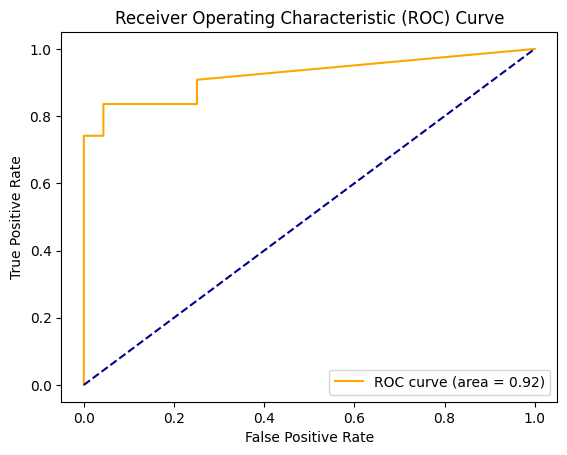

ROC AUC: 0.920


In [26]:
# UPDATED

import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'results' is your DataFrame and 'distance' is the score to predict conformity

# Inverting the 'distance' scores because higher scores indicate non-conformity
# We invert the scores for ROC AUC calculation because roc_auc_score expects higher values
# to indicate higher likelihood of the positive class
inverted_scores = 1 - results['distance']

# Calculate the ROC curve and AUC using inverted scores
fpr, tpr, thresholds = roc_curve(results['conform'], inverted_scores, pos_label=1)
roc_auc = roc_auc_score(results['conform'], inverted_scores)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC
print(f"ROC AUC: {roc_auc:.3f}")

# Descriptive Statistics for Model_A

In [40]:
cases = len(dataframe["@@case_index"])
print("number of cases:" , cases)

number of cases: 60849


In [28]:
# Calculate the length of each array
grouped['length'] = grouped['trace'].apply(len)

# Calculate minimum length of activities
min_length = grouped['length'].min()

# Calculate maximum length of activities
max_length = grouped['length'].max()

# Calculate average length of activities
average_length = grouped['length'].mean()

print(f"Minimum length of activities: {min_length}")
print(f"Maximum length of activities: {max_length}")
print(f"Average length of activities: {average_length:.1f}")

Minimum length of activities: 3
Maximum length of activities: 8
Average length of activities: 4.6


In [41]:
# Assuming 'grouped' is your dataframe, 'traces' is the column with trace data, and 'conform' is the column that indicates conformity

# Convert the list of activities in 'traces' to a tuple, which is hashable and can be used to identify unique values
results['trace'] = results['trace'].apply(tuple)

# Filter the dataframe where 'conform' is 0
non_conform_traces = results[results['conform'] == 0]['trace']

# Calculate the number of unique non-conforming traces
unique_non_conform_traces = non_conform_traces.nunique()

print(f"Number of unique non-conforming traces: {unique_non_conform_traces}")

Number of unique non-conforming traces: 7
